In [207]:
# Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from astropy.constants import c
from astropy import units as u

<h5> Correct for noise using wavelet denoising </h5>

In [208]:
"""
    Removes noise from the spectrum using wavelet decomposition 
    Name:       denoise()
    Parameters: 
                flux: flux data from the spectrum
                wavelet = 'db4': wavelet family (Daubechies w/ 4 vanishing moments)
                level = 1: first-level approx and detail coefficients
                threshold_type = 'soft': threshold type

    Returns:
                denoised_flux: flux without noise
"""
def denoise(flux, wavelet='db4', level=1, threshold_type='soft'):
    # Perform wavelet decomposition and get coefficients
    coeffs = pywt.wavedec(flux, wavelet, level=level)

    # Calculate the threshold
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(flux)))

    # Apply threshold to detail coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode=threshold_type)

    # Reconstruct the denoised flux
    denoised_flux = pywt.waverec(coeffs, wavelet)

    return denoised_flux



In [209]:
# Load spectrum
data = fits.getdata('hlsp_space_hst_stis_toi-1201_g140m_v1_component-spec.fits')
w, f , e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
mask = (w > 1210) & (w < 1221)

# Denoise the spectrum
flux_denoised = denoise(f[mask]) # already masked!

# Make sure array sizes are consitent
try:
    assert len(w[mask]) == len(flux_denoised)
except AssertionError as e:
    flux_denoised = np.delete(flux_denoised, -1)

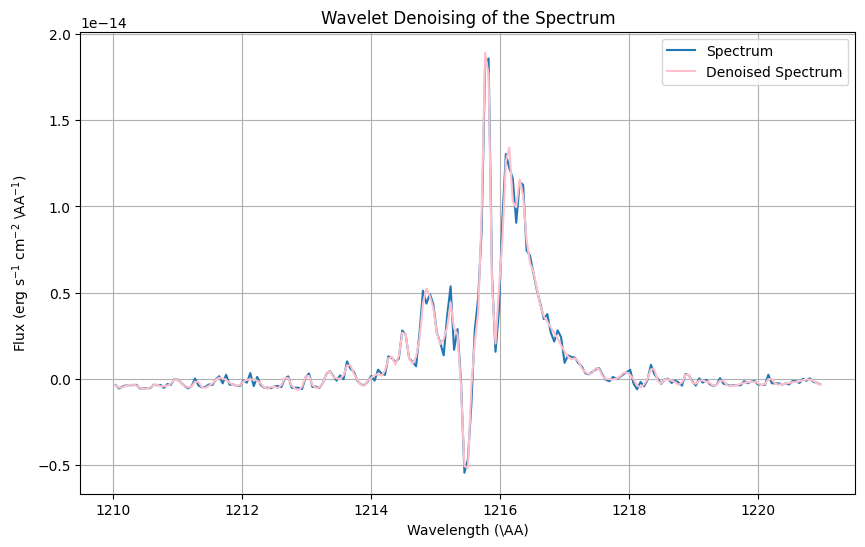

In [210]:
# Plot the updated spectrum

plt.figure(figsize=(10, 6))
plt.plot(w[mask], f[mask], label='Spectrum')
plt.plot(w[mask], flux_denoised, label='Denoised Spectrum', color='pink')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend()
plt.title('Wavelet Denoising of the Spectrum')
plt.grid(True)
plt.show()

<h5> Prepare the data </h5> 

In [211]:
# Normalize the wavelengths and denoised flux
normalized_denoised_flux = (flux_denoised - np.min(flux_denoised)) / (np.max(flux_denoised) - np.min(flux_denoised))
normalized_x = (w[mask] - np.min(w[mask])) / (np.max(w[mask]) - np.min(w[mask]))

# Split into training and validation sets (80% training)
num_samples = len(normalized_x)
train_size = int(0.8 * num_samples)

x_train, x_val = normalized_x[:train_size], normalized_x[train_size:]
flux_train, flux_val = normalized_denoised_flux[:train_size], normalized_denoised_flux[train_size:] 

# Organize features
x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).view(-1, 1)
flux_train_tensor = torch.tensor(flux_train, dtype=torch.float32).view(-1, 1)

# Organize labels
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).view(-1, 1)
flux_val_tensor = torch.tensor(flux_val, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, flux_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val_tensor, flux_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

u_true = normalized_denoised_flux


**** will use approximate alpha_x so it can be used in the reconstruction ****

<h5> PINN without α(x) Ground Truth</h5>
<p>Works by:

- 
</p>

In [212]:
# Constants
lya_lambda = 1215.67*u.Angstrom
lya_lambda = lya_lambda.to(u.m) # INSTEAD CONVERT C TO ANGSTROMS BECAUSE THE DATA IS IN ANGSTROMS   

# Define the PINN model (have to figure out how to take absorbtion into account)
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # 1 input dimension (normalized wavelength), 64 hidden units
        self.fc2 = nn.Linear(64, 64)  # 64 hidden units
        self.fc3 = nn.Linear(64, 1)  # 1 output dimension (predicted flux)

        self.alpha_x = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        flux_pred = self.fc3(x)
        return flux_pred

In [215]:
"""
    use radiative transfer equation (check logic)
        ∂I/∂x = -α(x) * I(x)
        x: flux
        α(x): absorption coefficient of the medium
        I(x): F(x) / (c * λ) -> F(x) = I(x) * cλ 
            F(x): flux
    ** model would learn to predict the absorption coefficent ** <- maybe 
"""
def pinn_loss(flux_pred, x_train_tensor, flux_true, pin_model):
    # MSE loss -> makes sure it learns the relationship between flux and wavelength
    data_loss = nn.MSELoss()(flux_pred, flux_true)

    # DONT USE DETACH -> but how do i perform operations on tensors ? fixed it :)


    # Radiative trainsfer equation to calculate intensity
    alpha_x = pin_model.alpha_x
    intensity_pred = flux_pred / (c.value * lya_lambda.value * alpha_x)
    # with torch.no_grad():
    #     detached_flux_pred = flux_pred.detach().numpy()
    #     detached_alpha_x = alpha_x.detach().numpy()
    #     intensity_pred = (detached_flux_pred / (c.value * lya_lambda.value * detached_alpha_x))
    
    # Calculate the partial derivative of the predicted flux with respect to the input wavelength (x) <- for physics constraint
    flux_pred_derivative = torch.autograd.grad(flux_pred, x_train_tensor, grad_outputs=torch.ones_like(flux_pred), create_graph=True)[0]

    # with torch.no_grad():
    #     detached_flux_pred_derivative = flux_pred_derivative.detach().numpy()

    # Calculate the residual 
    residual = flux_pred_derivative + alpha_x * flux_pred - intensity_pred

    # Convert the residual to a tensor
    residual_tensor = torch.tensor(residual, dtype=torch.float32)

    # Physics constraint loss 
    physics_loss = torch.mean(torch.square(residual_tensor))

    return data_loss + physics_loss


In [216]:
# Intialize the model and set up the optimizier
pin_model = PINNModel()
optimizer = torch.optim.Adam(pin_model.parameters(), lr=0.001)

# Traing Loop
num_epochs = 1000

for epoch in range(num_epochs):

    pin_model.train()
    optimizer.zero_grad()

    # Forward pass to predict flux
    flux_pred = pin_model(x_train_tensor)
    flux_pred.requires_grad_(True)

    # Calculate the PINN loss based on the physics constraint and true flux values
    loss = pinn_loss(flux_pred, x_train_tensor, flux_train_tensor, pin_model)

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Validation set
    with torch.no_grad():
        pin_model.eval()  # Set the model to evaluation mode
        val_flux_pred = pin_model(x_val_tensor)
        val_loss = pinn_loss(val_flux_pred, x_val_tensor, flux_val_tensor, pin_model)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    # Convert the tensors to numpy arrays using .detach().numpy() for any operations outside the computation graph
    flux_pred_np = flux_pred.detach().numpy()
    loss_value = loss.detach().numpy()
    val_loss_value = val_loss.detach().numpy()


C:\Users\bella\AppData\Local\Temp\ipykernel_18004\3063116065.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  residual_tensor = torch.tensor(residual, dtype=torch.float32)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn